In [ ]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing as prep
import time


In [ ]:
import io
from google.colab import files
uploaded = files.upload()
ef = pd.read_csv(io.StringIO(uploaded['pricelog.csv'].decode('utf-8')))


Saving pricelog.csv to pricelog (1).csv


In [ ]:
df = ef.iloc[5:len(ef)]
df = df[['price', 'vwap']]
df['pricelead'] = df['price'].shift(-100)
df = df.dropna(subset=['pricelead'])
df

,price,vwap,pricelead
5,414.4,415.056866,413.85
6,414.4,415.055404,413.85
7,414.4,415.047936,413.85
8,414.4,415.037662,413.85
9,414.4,415.044586,413.85
...,...,...,...
57436,417.8,418.110518,417.50
57437,417.8,418.105578,417.45
57438,417.8,418.104810,417.45
57439,417.8,418.102736,417.45


In [ ]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns) - 1
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9* result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1, :-1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1, :-1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

window = 100
X_train, y_train, X_test, y_test = preprocess_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (51602, 100, 2)
y_train (51602,)
X_test (5733, 100, 2)
y_test (5733,)


In [ ]:
def build_model(layers):
    model = Sequential()
    model.add(Bidirectional(LSTM(return_sequences=True, input_shape=(100, 2), units=50)))
    model.add(Dropout(0.4))

    model.add(Bidirectional(LSTM(
        layers[2],
        return_sequences=False)))
    model.add(Dropout(0.3))

    model.add(Dense(
        units=1))
    model.add(Activation("linear"))
    
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


In [ ]:
model = build_model([X_train.shape[2], window, 100, 1])


Compilation Time :  0.006289005279541016


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    verbose=0)

In [ ]:

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.03 MSE (0.18 RMSE)
Test Score: 0.43 MSE (0.65 RMSE)


In [ ]:
X_train, y_train, X_test, y_test = preprocess_data(df, window)

diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

prediction = pd.DataFrame({'Pred': pred[:, 0]})
value = prediction.iloc[-1]


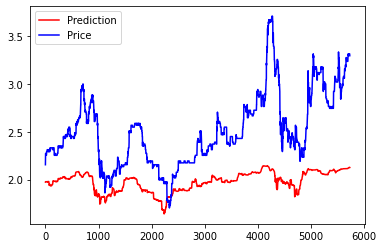

In [ ]:
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt
currentprice = X_test[:, 0][:, 0]
plt.plot(prediction, color='red', label='Prediction')
plt.plot(currentprice, color='blue', label='Price')
plt.legend(loc='upper left')
plt.show()